## Optimizing Performance and VRAM Usage

#### Optimization via `enabling model CPU offload`

In [1]:
import diffusers
print(diffusers.__version__)


C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.31.0.dev0


In [24]:
import torch
from diffusers import StableDiffusionPipeline
import tomesd

# Load the model
text2img_pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1")

text2img_pipe.to("cuda")  # Move the pipeline to GPU


# Create a generator on GPU
generator = torch.Generator(device='cuda')

# Generate the image
prompt = "Draw satellite image high quality"
image = text2img_pipe(
    prompt=prompt,
    generator=generator
).images[0]

# Save or display the image
# image.save("output_image.png")

# torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


In [31]:
prompt = "Draw satellite image high quality"
image = text2img_pipe(
    prompt=prompt,
    generator=generator
).images[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s]


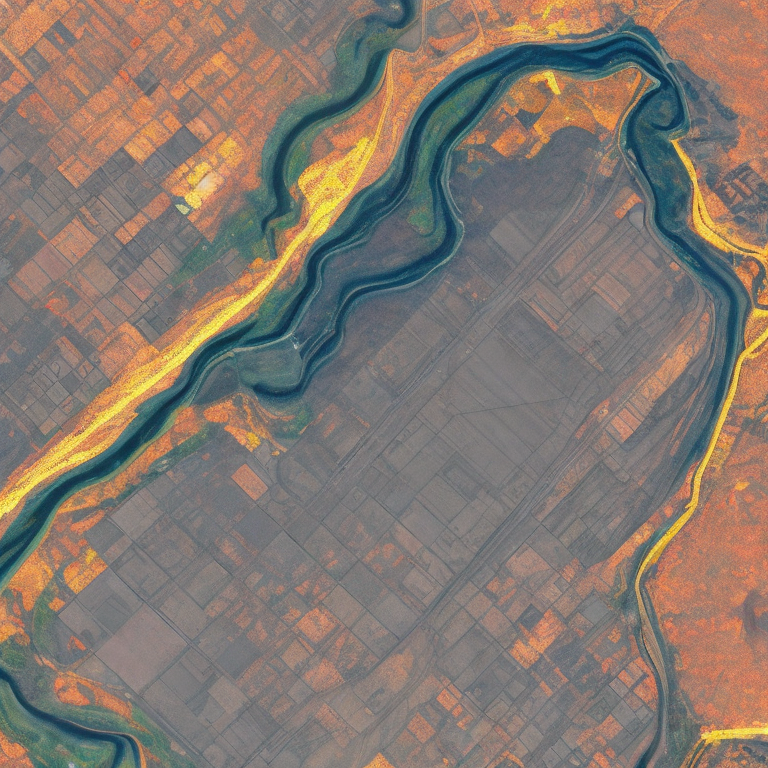

In [32]:
image

## Обучение модели на кастомном датасете

#### Разбиение датасета на блоки 512x512

In [11]:
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import logging
from sklearn.model_selection import train_test_split  # Для разделения данных

# Параметры
image_size = 512
filtered_threshold = 0.3  # Порог для сохранения в filtered (30%)

# Путь к датасету
dataset_dir = r'C:\Users\Jet\Desktop\datasets\спутники\dataset_skoltech'
output_dirs = {
    'train': 'dataset_skoltech/train_divided',
    'val': 'dataset_skoltech/val_divided',
    'test': 'dataset_skoltech/test_divided',
    'train_filtered': 'dataset_skoltech/train/train_filtered',
    'val_filtered': 'dataset_skoltech/val/val_filtered',
    'test_filtered': 'dataset_skoltech/test/test_filtered',
}

# Настройка логирования
logging.basicConfig(filename='preprocessing.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Функция для разбиения изображения на 512x512 части и фильтрации
def divide_image(image, mask, split, image_basename, image_save_dir, mask_save_dir, filtered_image_dir, filtered_mask_dir, threshold):
    img_w, img_h = image.size

    # Считаем количество полных кропов по ширине и высоте
    num_crops_w = img_w // image_size
    num_crops_h = img_h // image_size

    saved_crops = 0
    filtered_crops = 0
    skipped_crops = 0

    for i in range(num_crops_w):
        for j in range(num_crops_h):
            left = i * image_size
            upper = j * image_size
            right = left + image_size
            lower = upper + image_size

            box = (left, upper, right, lower)
            img_crop = image.crop(box)
            mask_crop = mask.crop(box)

            # Проверка размеров кропа
            if img_crop.size != (image_size, image_size) or mask_crop.size != (image_size, image_size):
                skipped_crops += 1
                continue  # Пропускаем кропы, которые не имеют размер 512x512

            # Создание уникального имени файла
            crop_name = f"{split}_{image_basename}_{left}_{upper}.png"

            # Сохранение изображений и масок в разделенные папки
            img_crop_save_path = os.path.join(image_save_dir, crop_name)
            mask_crop_save_path = os.path.join(mask_save_dir, crop_name)

            img_crop.save(img_crop_save_path)
            mask_crop.save(mask_crop_save_path)
            saved_crops += 1

            # Проверка процента аннотации на маске для фильтрации
            mask_crop_np = np.array(mask_crop)
            if np.mean(mask_crop_np) > threshold:
                filtered_img_crop_save_path = os.path.join(filtered_image_dir, crop_name)
                filtered_mask_crop_save_path = os.path.join(filtered_mask_dir, crop_name)

                img_crop.save(filtered_img_crop_save_path)
                mask_crop.save(filtered_mask_crop_save_path)
                filtered_crops += 1

    logging.info(f"Split: {split} | Сохранено кропов: {saved_crops}, Отфильтровано: {filtered_crops}, Пропущено: {skipped_crops}")

# Создание выходных директорий
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dirs[split], 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dirs[split], 'masks'), exist_ok=True)
    os.makedirs(os.path.join(output_dirs[f'{split}_filtered'], 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dirs[f'{split}_filtered'], 'masks'), exist_ok=True)

# Проход по папкам train, val, test
for split in ['train', 'val', 'test']:
    image_dir = os.path.join(dataset_dir, split, 'images')
    mask_dir = os.path.join(dataset_dir, split, 'masks')
    
    output_image_dir = os.path.join(output_dirs[split], 'images')
    output_mask_dir = os.path.join(output_dirs[split], 'masks')

    filtered_image_dir = os.path.join(output_dirs[f'{split}_filtered'], 'images')
    filtered_mask_dir = os.path.join(output_dirs[f'{split}_filtered'], 'masks')

    # Проход по всем изображениям и маскам
    for image_name in tqdm(os.listdir(image_dir), desc=f"Processing {split}"):
        if image_name.lower().endswith('.png'):
            image_path = os.path.join(image_dir, image_name)
            
            # Изменяем название файла для маски (замена "image" на "mask")
            mask_name = image_name.replace("train_image", "train_mask").replace("val_image", "val_mask").replace("test_image", "test_mask")
            mask_path = os.path.join(mask_dir, mask_name)

            # Проверяем существование файла маски
            if not os.path.exists(mask_path):
                logging.warning(f'Файл маски не найден: {mask_path}')
                continue

            # Открытие изображения и маски
            try:
                image = Image.open(image_path).convert("RGB")
                mask = Image.open(mask_path).convert("L")  # Предполагаем, что маска в градациях серого
            except Exception as e:
                logging.error(f"Ошибка при открытии {image_path} или {mask_path}: {e}")
                continue

            # Получаем базовое имя файла без расширения
            image_basename = os.path.splitext(image_name)[0]

            # Разделение и сохранение
            divide_image(image, mask, split, image_basename, output_image_dir, output_mask_dir, filtered_image_dir, filtered_mask_dir, threshold=filtered_threshold)

# Функция для подсчета количества файлов в папке
def count_files_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Вывод статистики
def print_folder_stats(output_dirs):
    print("\nСтатистика по папкам:")
    for split in ['train', 'val', 'test']:
        total_images = count_files_in_folder(os.path.join(output_dirs[split], 'images'))
        total_masks = count_files_in_folder(os.path.join(output_dirs[split], 'masks'))
        filtered_images = count_files_in_folder(os.path.join(output_dirs[f'{split}_filtered'], 'images'))
        filtered_masks = count_files_in_folder(os.path.join(output_dirs[f'{split}_filtered'], 'masks'))

        print(f"\n{split.capitalize()}:")
        print(f"  Разделенные изображения: {total_images}")
        print(f"  Разделенные маски: {total_masks}")
        print(f"  Фильтрованные изображения: {filtered_images}")
        print(f"  Фильтрованные маски: {filtered_masks}")

        # Логирование статистики
        logging.info(f"\n{split.capitalize()}:")
        logging.info(f"  Разделенные изображения: {total_images}")
        logging.info(f"  Разделенные маски: {total_masks}")
        logging.info(f"  Фильтрованные изображения: {filtered_images}")
        logging.info(f"  Фильтрованные маски: {filtered_masks}")

    logging.info("Предварительная обработка завершена.")

# Выводим статистику по папкам
print_folder_stats(output_dirs)


Processing train:  33%|█████████████████████▋                                           | 5/15 [01:47<04:10, 25.05s/it]C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (99969780 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing val:   0%|                                                                            | 0/2 [00:00<?, ?it/s]C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (108245178 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Processing test: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:20<00:00, 10.10s/it]



Статистика по папкам:

Train:
  Разделенные изображения: 2108
  Разделенные маски: 2108
  Фильтрованные изображения: 1471
  Фильтрованные маски: 1471

Val:
  Разделенные изображения: 456
  Разделенные маски: 456
  Фильтрованные изображения: 348
  Фильтрованные маски: 348

Test:
  Разделенные изображения: 162
  Разделенные маски: 162
  Фильтрованные изображения: 133
  Фильтрованные маски: 133


#### Сохранение только изображений с большим количеством целевых объектов 

Проверено файлов: 162
Файлы, которые проходят порог 10.0%: 84 (51.85%)
Файлы, которые НЕ проходят порог 10.0%: 78 (48.15%)

Примеры масок, которые проходят порог:


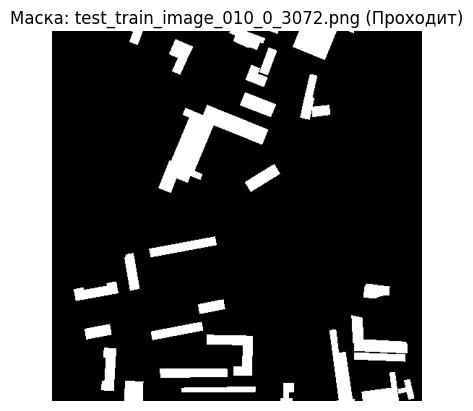

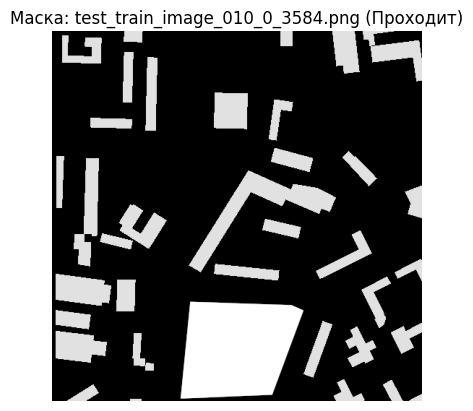

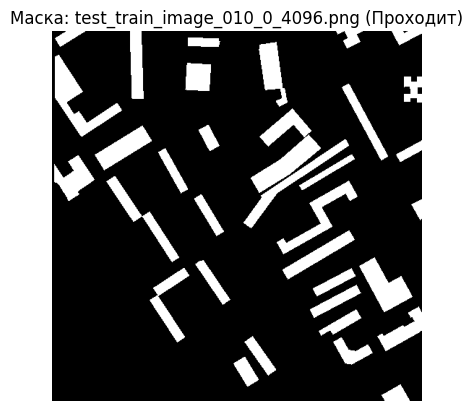


Примеры масок, которые НЕ проходят порог:


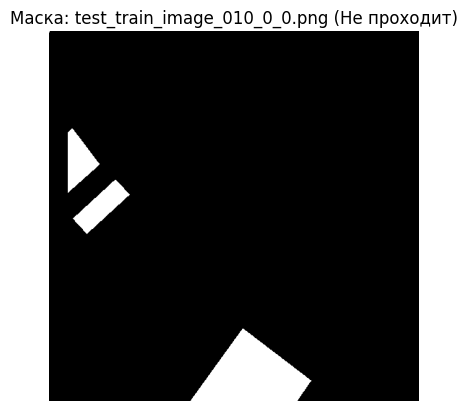

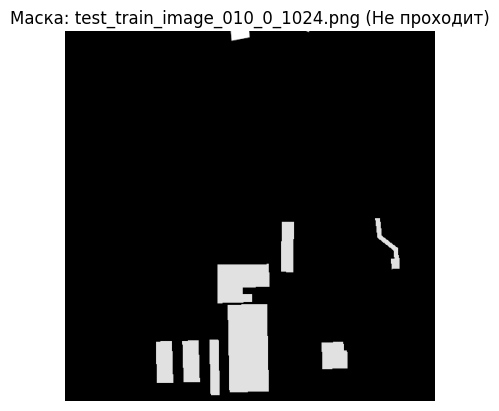

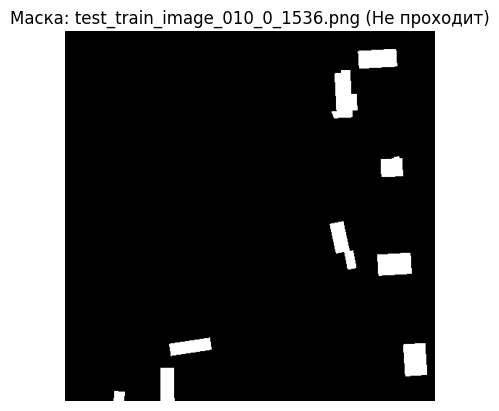

In [15]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def check_mask_threshold(mask_path, threshold=0.3):
    """
    Проверяет, что хотя бы threshold процентов пикселей на маске не равны 0.
    
    :param mask_path: Путь к файлу маски (изображению)
    :param threshold: Порог в процентах, по умолчанию 0.3 (30%)
    :return: True, если процент пикселей не равных 0 больше или равен threshold, иначе False
    """
    # Открываем изображение маски
    mask = Image.open(mask_path)
    
    # Преобразуем маску в массив NumPy
    mask_np = np.array(mask)
    
    # Считаем общее количество пикселей
    total_pixels = mask_np.size
    
    # Считаем количество пикселей, не равных 0
    non_zero_pixels = np.count_nonzero(mask_np)
    
    # Рассчитываем процент пикселей, не равных 0
    non_zero_percentage = non_zero_pixels / total_pixels
    
    # Возвращаем True, если процент пикселей не равных 0 больше или равен порогу
    return non_zero_percentage >= threshold

def check_all_masks_in_folder(folder_path, threshold=0.3, display_limit=3):
    """
    Проверяет все маски в указанной папке и выводит статистику по порогу threshold,
    а также визуализирует несколько масок, которые проходят и не проходят порог.
    
    :param folder_path: Путь к папке с масками
    :param threshold: Порог в процентах, по умолчанию 0.3 (30%)
    :param display_limit: Максимальное количество масок для отображения (проходящих и не проходящих)
    """
    total_files = 0
    passed_files = 0
    passed_examples = []
    failed_examples = []

    # Перебираем все файлы в папке
    for mask_file in os.listdir(folder_path):
        # Проверяем, что файл имеет расширение .png
        if mask_file.endswith('.png'):
            total_files += 1
            mask_path = os.path.join(folder_path, mask_file)
            # Проверяем маску на соответствие порогу
            if check_mask_threshold(mask_path, threshold):
                passed_files += 1
                if len(passed_examples) < display_limit:
                    passed_examples.append(mask_path)
            else:
                if len(failed_examples) < display_limit:
                    failed_examples.append(mask_path)

    if total_files > 0:
        # Подсчитываем процент файлов, которые прошли и не прошли проверку
        passed_percentage = (passed_files / total_files) * 100
        failed_percentage = 100 - passed_percentage

        print(f"Проверено файлов: {total_files}")
        print(f"Файлы, которые проходят порог {threshold * 100}%: {passed_files} ({passed_percentage:.2f}%)")
        print(f"Файлы, которые НЕ проходят порог {threshold * 100}%: {total_files - passed_files} ({failed_percentage:.2f}%)")
    else:
        print("В папке нет файлов для проверки.")

    # Визуализация нескольких масок, которые проходят порог
    if passed_examples:
        print("\nПримеры масок, которые проходят порог:")
        for mask_path in passed_examples:
            mask = Image.open(mask_path)
            plt.figure()
            plt.title(f"Маска: {os.path.basename(mask_path)} (Проходит)")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.show()

    # Визуализация нескольких масок, которые не проходят порог
    if failed_examples:
        print("\nПримеры масок, которые НЕ проходят порог:")
        for mask_path in failed_examples:
            mask = Image.open(mask_path)
            plt.figure()
            plt.title(f"Маска: {os.path.basename(mask_path)} (Не проходит)")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.show()
# Desktop/mytrain/dataset_skoltech/test
# Desktop/mytrain/dataset_skoltech/test_divided/masks/test_train_image_011_4096_4608.png
folder_path = r'dataset_skoltech/test_divided/masks'
check_all_masks_in_folder(folder_path, threshold=0.1, display_limit=3)



In [16]:
import os
import numpy as np
from PIL import Image

def check_mask_threshold(mask_path, threshold=0.1):
    """
    Проверяет, что хотя бы threshold процентов пикселей на маске не равны 0.
    
    :param mask_path: Путь к файлу маски (изображению)
    :param threshold: Порог в процентах, по умолчанию 0.3 (30%)
    :return: True, если процент пикселей не равных 0 больше или равен threshold, иначе False
    """
    # Открываем изображение маски
    mask = Image.open(mask_path)
    
    # Преобразуем маску в массив NumPy
    mask_np = np.array(mask)
    
    # Считаем общее количество пикселей
    total_pixels = mask_np.size
    
    # Считаем количество пикселей, не равных 0
    non_zero_pixels = np.count_nonzero(mask_np)
    
    # Рассчитываем процент пикселей, не равных 0
    non_zero_percentage = non_zero_pixels / total_pixels
    
    # Возвращаем True, если процент пикселей не равных 0 больше или равен порогу
    return non_zero_percentage >= threshold

def filter_masks_in_folder(folder_path, threshold=0.1):
    """
    Проверяет все маски в указанной папке и оставляет только те, которые проходят порог.
    
    :param folder_path: Путь к папке с масками
    :param threshold: Порог в процентах, по умолчанию 0.3 (30%)
    """
    images_folder = os.path.join(folder_path, 'images')
    masks_folder = os.path.join(folder_path, 'masks')
    
    if not os.path.exists(images_folder) or not os.path.exists(masks_folder):
        print(f"Папки {images_folder} или {masks_folder} не существуют. Пропускаем.")
        return

    # Перебираем все файлы в папке с масками
    for mask_file in os.listdir(masks_folder):
        if mask_file.endswith('.png'):
            mask_path = os.path.join(masks_folder, mask_file)
            image_path = os.path.join(images_folder, mask_file)  # Предполагаем, что имена файлов совпадают

            # Проверяем, проходит ли маска порог
            if not check_mask_threshold(mask_path, threshold):
                # Если маска не проходит порог, удаляем и изображение, и маску
                print(f"Удаляем маску и изображение: {mask_file}")
                os.remove(mask_path)
                if os.path.exists(image_path):
                    os.remove(image_path)

# Применение функции к папкам train_filtered, val_filtered, test_filtered
filtered_folders = ['train_filtered', 'val_filtered', 'test_filtered']
base_path = 'dataset_skoltech'

for folder in filtered_folders:
    folder_path = os.path.join(base_path, folder)
    print(f"Обрабатываем папку: {folder_path}")
    filter_masks_in_folder(folder_path, threshold=0.1)


Обрабатываем папку: dataset_skoltech\train_filtered
Папки dataset_skoltech\train_filtered\images или dataset_skoltech\train_filtered\masks не существуют. Пропускаем.
Обрабатываем папку: dataset_skoltech\val_filtered
Папки dataset_skoltech\val_filtered\images или dataset_skoltech\val_filtered\masks не существуют. Пропускаем.
Обрабатываем папку: dataset_skoltech\test_filtered
Папки dataset_skoltech\test_filtered\images или dataset_skoltech\test_filtered\masks не существуют. Пропускаем.


## Генерация caption.csv

In [19]:
import os
import csv

# Define the directory containing your images
image_dir = r'dataset_skoltech\train_divided\images'

# Define the output CSV file
output_csv = 'captions.csv'

# Define the caption text
caption_text = "Draw satellite image high quality and perfect resolution"

# Collect all image filenames in the directory
image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Write the CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['filename', 'caption'])
    # Write each image filename with the associated caption
    for filename in image_filenames:
        writer.writerow([filename, caption_text])

print(f"CSV file '{output_csv}' has been created successfully.")


CSV file 'captions.csv' has been created successfully.


## Обучение модели

In [1]:
import os
import pandas as pd
import torch
from accelerate import Accelerator
from diffusers import DDPMScheduler, StableDiffusionPipeline
from peft import LoraConfig
from peft.utils import get_peft_model_state_dict
from datasets import Dataset
from torchvision import transforms
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers.optimization import get_scheduler
from diffusers.utils import convert_state_dict_to_diffusers
from PIL import Image
import gc  # Для очистки памяти
from sklearn.model_selection import train_test_split  # Для разделения данных
import logging  # Для логирования

# Настройка логирования
logging.basicConfig(filename='training.log', level=logging.INFO)

# Основная функция для тренировки LoRA
def main():
    # Инициализируем ускоритель обучения (Accelerator) без смешанной точности
    accelerator = Accelerator(
        gradient_accumulation_steps=4,  # Увеличенный шаг накопления градиентов
        mixed_precision="no"  # Отключаем смешанную точность
    )
    device = accelerator.device
    print(f"Accelerator device: {device}")

    # Определение гиперпараметров
    output_dir = "output_dir"
    pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
    lora_rank = 4
    lora_alpha = 4
    learning_rate = 5e-5  # Изменено на более низкое значение
    adam_beta1, adam_beta2 = 0.9, 0.999
    adam_weight_decay = 1e-2
    adam_epsilon = 1e-08
    train_data_dir = r"C:\Users\Jet\Desktop\mytrain\dataset_skoltech\train\train_filtered\images"  # Путь к данным
    captions_file = r"C:\Users\Jet\Desktop\mytrain\captions.csv"  # Путь к captions.csv
    resolution = 512  # Изменено на 512 для сохранения оригинального размера
    center_crop = True
    random_flip = True
    train_batch_size = 2  # Уменьшенный размер батча
    num_train_epochs = 5
    lr_scheduler_name = "linear"  # Изменено на линейный планировщик
    num_warmup_steps = 500         # Добавлены warmup шаги
    max_grad_norm = 1.0
    diffusion_scheduler = DDPMScheduler

    # Загружаем модель Stable Diffusion с типом данных float32
    noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
    weight_dtype = torch.float32  # Используем float32
    pipe = StableDiffusionPipeline.from_pretrained(
        pretrained_model_name_or_path,
        torch_dtype=weight_dtype
    ).to(device)
    print("Модель Stable Diffusion загружена и перемещена на устройство.")

    tokenizer, text_encoder = pipe.tokenizer, pipe.text_encoder
    vae, unet = pipe.vae, pipe.unet

    # Перенос моделей на устройство (GPU/CPU) с типом float32
    vae = vae.to(device, dtype=torch.float32)
    unet = unet.to(device, dtype=torch.float32)
    text_encoder = text_encoder.to(device, dtype=torch.float32)
    print("Модели vae, unet и text_encoder перемещены на устройство.")

    # Замораживаем веса моделей (vae, unet, text_encoder)
    unet.requires_grad_(False)
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    print("Веса моделей vae, unet и text_encoder заморожены.")

    # Настройка LoRA (адаптация с низким рангом)
    unet_lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"]
    )
    unet.add_adapter(unet_lora_config)
    print("LoRA адаптер добавлен к unet.")

    # Препроцессинг изображений
    train_transforms = transforms.Compose([
        transforms.Resize(resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(resolution) if center_crop else transforms.RandomCrop(resolution),
        transforms.RandomHorizontalFlip() if random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),  # Преобразование изображений в тензоры
        transforms.Normalize([0.5], [0.5])  # Приведение значений пикселей к диапазону [-1, 1]
    ])

    # Чтение файла с аннотациями
    captions_df = pd.read_csv(captions_file)

    # Создаем датасет из изображений и аннотаций
    data = []
    for index, row in captions_df.iterrows():
        image_path = os.path.join(train_data_dir, row['filename'])
        if os.path.exists(image_path):
            data.append({"image": image_path, "caption": row["caption"]})

    # Разделение данных на тренировочные и валидационные
    train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
    train_dataset = Dataset.from_pandas(pd.DataFrame(train_data))
    val_dataset = Dataset.from_pandas(pd.DataFrame(val_data))
    print(f"Тренировочный датасет создан с {len(train_dataset)} примерами.")
    print(f"Валидационный датасет создан с {len(val_dataset)} примерами.")

    # Определение функции препроцессинга
    def preprocess_train(examples):
        # Открываем изображения и применяем преобразования
        images = [Image.open(image_path).convert("RGB") for image_path in examples["image"]]
        pixel_values = [train_transforms(image) for image in images]  # Список тензоров
        pixel_values = torch.stack(pixel_values).to(device, dtype=torch.float32)  # Перевод в float32 и перенос на устройство

        # Токенизируем текстовые аннотации
        captions = examples["caption"]
        inputs = tokenizer(
            captions,
            padding="max_length",
            truncation=True,
            max_length=tokenizer.model_max_length,
            return_tensors="pt"
        )
        input_ids = inputs.input_ids.to(device)  # Перенос на устройство

        # Отладочные принты
        if accelerator.is_main_process:
            print(f"preprocess_train - pixel_values type: {type(pixel_values)}, dtype: {pixel_values.dtype}, shape: {pixel_values.shape}")
            print(f"preprocess_train - input_ids type: {type(input_ids)}, shape: {input_ids.shape}")

        return {"pixel_values": pixel_values, "input_ids": input_ids}

    # Применение препроцессинга к данным
    train_dataset = train_dataset.map(preprocess_train, batched=True, remove_columns=["image", "caption"])
    val_dataset = val_dataset.map(preprocess_train, batched=True, remove_columns=["image", "caption"])
    print("Препроцессинг данных завершен.")

    # Установка формата данных на torch
    train_dataset.set_format(type="torch", columns=["pixel_values", "input_ids"])
    val_dataset.set_format(type="torch", columns=["pixel_values", "input_ids"])
    print("Dataset format set to torch.")

    # Создание DataLoader для обучения и валидации
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, batch_size=train_batch_size, pin_memory=False  # Отключаем pin_memory
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, shuffle=False, batch_size=train_batch_size, pin_memory=False
    )
    print("DataLoader создан.")

    # Инициализация оптимизатора AdamW
    lora_layers = filter(lambda p: p.requires_grad, unet.parameters())
    optimizer = torch.optim.AdamW(
        lora_layers,
        lr=learning_rate,
        betas=(adam_beta1, adam_beta2),
        weight_decay=adam_weight_decay,
        eps=adam_epsilon
    )
    print("Оптимизатор AdamW инициализирован.")

    # Настройка планировщика скорости обучения
    lr_scheduler = get_scheduler(
        lr_scheduler_name,
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_train_epochs * len(train_dataloader)
    )
    print("Планировщик скорости обучения настроен.")

    # Подготовка моделей и оптимизатора с помощью Accelerator
    unet, optimizer, train_dataloader, lr_scheduler, val_dataloader = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler, val_dataloader
    )
    print("Модели и оптимизаторы подготовлены Accelerator.")

    # Основной цикл тренировки
    for epoch in range(num_train_epochs):
        unet.train()
        progress_bar = tqdm(range(len(train_dataloader)), desc=f"Epoch {epoch + 1}/{num_train_epochs}")

        epoch_loss = 0.0  # Инициализация переменной для накопления потерь
        for step, batch in enumerate(train_dataloader):
            # Подготовка данных для обучения (на устройстве уже перемещены Accelerator)
            pixel_values = batch["pixel_values"]  # float32 и на устройстве
            input_ids = batch["input_ids"]  # На устройстве

            # Добавьте принты для отслеживания типов данных
            if step == 0 and accelerator.is_main_process:
                print(f"Training Loop - pixel_values type: {type(pixel_values)}, dtype: {pixel_values.dtype}, shape: {pixel_values.shape}, device: {pixel_values.device}")
                print(f"Training Loop - input_ids type: {type(input_ids)}, shape: {input_ids.shape}, device: {input_ids.device}")

            # Кодирование изображений через VAE
            try:
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents *= vae.config.scaling_factor
            except Exception as e:
                print(f"Ошибка при кодировании через VAE: {e}")
                print(f"Тип pixel_values: {type(pixel_values)}, dtype: {pixel_values.dtype}, устройство: {pixel_values.device}")
                raise e

            noise = torch.randn_like(latents)  # Шум на устройстве
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()

            # Токенизация текста
            encoder_hidden_states = text_encoder(input_ids).last_hidden_state  # Используем текстовые токены

            # Добавление шума
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Предсказание модели и расчет потерь
            try:
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            except Exception as e:
                print(f"Ошибка при предсказании модели: {e}")
                print(f"Тип noisy_latents: {type(noisy_latents)}, dtype: {noisy_latents.dtype}, устройство: {noisy_latents.device}")
                raise e

            target = noise if noise_scheduler.config.prediction_type == "epsilon" else noise_scheduler.get_velocity(latents, noise, timesteps)
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            epoch_loss += loss.item()  # Накопление потерь

            # Обновление весов и шаг оптимизации
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            progress_bar.update(1)
            progress_bar.set_postfix(loss=loss.item())

            # Очистка кэша памяти каждые 10 шагов, чтобы освободить память
            if step % 10 == 0 and accelerator.is_main_process:
                gc.collect()
                torch.cuda.empty_cache()
                print("Кэш памяти очищен.")

            # Логирование потерь
            if accelerator.is_main_process:
                logging.info(f"Epoch {epoch + 1}, Step {step + 1}, Loss: {loss.item()}")

        # Вычисление среднего значения потерь за эпоху
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        print(f"Эпоха {epoch + 1} завершена. Среднее значение потерь: {avg_epoch_loss:.4f}")
        logging.info(f"Epoch {epoch + 1} завершена. Среднее значение потерь: {avg_epoch_loss:.4f}")





        # Валидация после каждой эпохи
        unet.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                pixel_values = batch["pixel_values"]
                input_ids = batch["input_ids"]

                # Кодирование изображений через VAE
                try:
                    latents = vae.encode(pixel_values).latent_dist.sample()
                    latents *= vae.config.scaling_factor
                except Exception as e:
                    print(f"Ошибка при кодировании через VAE: {e}")
                    raise e

                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()

                # Токенизация текста
                encoder_hidden_states = text_encoder(input_ids).last_hidden_state

                # Добавление шума
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Предсказание модели и расчет потерь
                try:
                    model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                except Exception as e:
                    print(f"Ошибка при предсказании модели: {e}")
                    raise e

                target = noise if noise_scheduler.config.prediction_type == "epsilon" else noise_scheduler.get_velocity(latents, noise, timesteps)
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Валидация завершена. Среднее значение потерь: {avg_val_loss:.4f}")
        logging.info(f"Валидация завершена. Среднее значение потерь: {avg_val_loss:.4f}")


        accelerator.wait_for_everyone()
        if accelerator.is_main_process:
            unet = unet.to(torch.float32)  # Убедитесь, что модель в float32 перед сохранением
            unwrapped_unet = accelerator.unwrap_model(unet)
            unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unwrapped_unet))
            StableDiffusionPipeline.save_lora_weights(output_dir, unet_lora_state_dict, safe_serialization=True)
            print("Модель LoRA сохранена.")

    # Сохранение модели LoRA
  

    accelerator.end_training()
    print("Обучение завершено.")

# Запуск основного процесса
if __name__ == "__main__":
    main()


C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accelerator device: cuda


Loading pipeline components...:  57%|█████████████████████████████▋                      | 4/7 [00:00<00:00,  5.61it/s]C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.71it/s]


Модель Stable Diffusion загружена и перемещена на устройство.
Модели vae, unet и text_encoder перемещены на устройство.
Веса моделей vae, unet и text_encoder заморожены.
LoRA адаптер добавлен к unet.
Тренировочный датасет создан с 1323 примерами.
Валидационный датасет создан с 148 примерами.


Map:   0%|                                                                             | 0/1323 [00:00<?, ? examples/s]

preprocess_train - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([1000, 3, 512, 512])
preprocess_train - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([1000, 77])


Map:  76%|█████████████████████████████████████████████████▉                | 1000/1323 [00:30<00:09, 32.68 examples/s]

preprocess_train - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([323, 3, 512, 512])
preprocess_train - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([323, 77])


Map:   0%|                                                                              | 0/148 [00:00<?, ? examples/s]

preprocess_train - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([148, 3, 512, 512])
preprocess_train - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([148, 77])


Map: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:02<00:00, 53.86 examples/s]


Препроцессинг данных завершен.
Dataset format set to torch.
DataLoader создан.
Оптимизатор AdamW инициализирован.
Планировщик скорости обучения настроен.
Модели и оптимизаторы подготовлены Accelerator.


Epoch 1/5:   0%|                                                                               | 0/662 [00:00<?, ?it/s]

Training Loop - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([2, 3, 512, 512]), device: cuda:0
Training Loop - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([2, 77]), device: cuda:0


C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\diffusers\models\attention_processor.py:2367: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
Epoch 1/5:   0%|                                                         | 1/662 [00:14<2:44:03, 14.89s/it, loss=0.704]

Кэш памяти очищен.


Epoch 1/5:   2%|▉                                                      | 11/662 [02:16<2:10:45, 12.05s/it, loss=0.0134]

Кэш памяти очищен.


Epoch 1/5:   3%|█▊                                                      | 21/662 [04:23<2:17:18, 12.85s/it, loss=0.222]

Кэш памяти очищен.


Epoch 1/5:   5%|██▌                                                    | 31/662 [06:32<2:17:19, 13.06s/it, loss=0.0134]

Кэш памяти очищен.


Epoch 1/5:   6%|███▍                                                    | 41/662 [08:39<2:13:10, 12.87s/it, loss=0.121]

Кэш памяти очищен.


Epoch 1/5:   8%|████▎                                                   | 51/662 [10:47<2:09:59, 12.77s/it, loss=0.205]

Кэш памяти очищен.


Epoch 1/5:   9%|█████                                                  | 61/662 [12:52<2:05:51, 12.56s/it, loss=0.0764]

Кэш памяти очищен.


Epoch 1/5:  11%|██████                                                  | 71/662 [14:58<2:05:31, 12.74s/it, loss=0.139]

Кэш памяти очищен.


Epoch 1/5:  12%|██████▊                                                 | 81/662 [17:07<2:05:16, 12.94s/it, loss=0.246]

Кэш памяти очищен.


Epoch 1/5:  14%|███████▋                                                | 91/662 [19:13<1:59:56, 12.60s/it, loss=0.247]

Кэш памяти очищен.


Epoch 1/5:  15%|████████▍                                              | 101/662 [21:21<2:00:36, 12.90s/it, loss=0.277]

Кэш памяти очищен.


Epoch 1/5:  17%|█████████▏                                             | 111/662 [23:28<1:56:33, 12.69s/it, loss=0.088]

Кэш памяти очищен.


Epoch 1/5:  18%|█████████▊                                            | 121/662 [25:35<1:55:57, 12.86s/it, loss=0.0144]

Кэш памяти очищен.


Epoch 1/5:  20%|██████████▉                                            | 131/662 [27:44<1:54:46, 12.97s/it, loss=0.269]

Кэш памяти очищен.


Epoch 1/5:  21%|███████████▌                                          | 141/662 [29:53<1:52:33, 12.96s/it, loss=0.0217]

Кэш памяти очищен.


Epoch 1/5:  23%|████████████▌                                          | 151/662 [32:02<1:50:49, 13.01s/it, loss=0.141]

Кэш памяти очищен.


Epoch 1/5:  24%|█████████████▏                                        | 161/662 [34:11<1:48:16, 12.97s/it, loss=0.0744]

Кэш памяти очищен.


Epoch 1/5:  26%|██████████████▏                                        | 171/662 [36:18<1:45:14, 12.86s/it, loss=0.065]

Кэш памяти очищен.


Epoch 1/5:  27%|███████████████                                        | 181/662 [38:28<1:44:01, 12.98s/it, loss=0.174]

Кэш памяти очищен.


Epoch 1/5:  29%|███████████████▊                                       | 191/662 [40:36<1:41:25, 12.92s/it, loss=0.234]

Кэш памяти очищен.


Epoch 1/5:  30%|████████████████▋                                      | 201/662 [42:44<1:38:56, 12.88s/it, loss=0.129]

Кэш памяти очищен.


Epoch 1/5:  32%|█████████████████▌                                     | 211/662 [44:52<1:36:40, 12.86s/it, loss=0.236]

Кэш памяти очищен.


Epoch 1/5:  33%|██████████████████                                    | 221/662 [47:01<1:36:13, 13.09s/it, loss=0.0535]

Кэш памяти очищен.


Epoch 1/5:  35%|███████████████████▏                                   | 231/662 [49:10<1:33:42, 13.05s/it, loss=0.315]

Кэш памяти очищен.


Epoch 1/5:  36%|████████████████████                                   | 241/662 [51:18<1:30:12, 12.86s/it, loss=0.111]

Кэш памяти очищен.


Epoch 1/5:  38%|████████████████████▊                                  | 251/662 [53:28<1:29:49, 13.11s/it, loss=0.241]

Кэш памяти очищен.


Epoch 1/5:  39%|████████████████████▉                                | 261/662 [55:38<1:27:53, 13.15s/it, loss=0.00298]

Кэш памяти очищен.


Epoch 1/5:  41%|█████████████████████▋                               | 271/662 [57:49<1:26:04, 13.21s/it, loss=0.00737]

Кэш памяти очищен.


Epoch 1/5:  42%|██████████████████████                              | 281/662 [1:00:00<1:23:45, 13.19s/it, loss=0.0489]

Кэш памяти очищен.


Epoch 1/5:  44%|███████████████████████▎                             | 291/662 [1:02:09<1:21:09, 13.12s/it, loss=0.477]

Кэш памяти очищен.


Epoch 1/5:  45%|████████████████████████                             | 301/662 [1:04:20<1:19:26, 13.20s/it, loss=0.487]

Кэш памяти очищен.


Epoch 1/5:  47%|████████████████████████▉                            | 311/662 [1:06:31<1:17:15, 13.21s/it, loss=0.543]

Кэш памяти очищен.


Epoch 1/5:  48%|█████████████████████████▏                          | 321/662 [1:08:43<1:15:05, 13.21s/it, loss=0.0547]

Кэш памяти очищен.


Epoch 1/5:  50%|██████████████████████████▌                          | 331/662 [1:10:54<1:12:46, 13.19s/it, loss=0.157]

Кэш памяти очищен.


Epoch 1/5:  52%|██████████████████████████▊                         | 341/662 [1:13:06<1:10:59, 13.27s/it, loss=0.0113]

Кэш памяти очищен.


Epoch 1/5:  53%|████████████████████████████                         | 351/662 [1:15:17<1:08:27, 13.21s/it, loss=0.208]

Кэш памяти очищен.


Epoch 1/5:  55%|████████████████████████████▎                       | 361/662 [1:17:25<1:03:04, 12.57s/it, loss=0.0437]

Кэш памяти очищен.


Epoch 1/5:  56%|█████████████████████████████▋                       | 371/662 [1:19:28<1:00:46, 12.53s/it, loss=0.139]

Кэш памяти очищен.


Epoch 1/5:  58%|███████████████████████████████▋                       | 381/662 [1:21:36<58:43, 12.54s/it, loss=0.194]

Кэш памяти очищен.


Epoch 1/5:  59%|████████████████████████████████▍                      | 391/662 [1:23:39<56:00, 12.40s/it, loss=0.195]

Кэш памяти очищен.


Epoch 1/5:  61%|█████████████████████████████████▉                      | 401/662 [1:25:42<53:55, 12.40s/it, loss=0.14]

Кэш памяти очищен.


Epoch 1/5:  62%|█████████████████████████████████▌                    | 411/662 [1:27:46<51:56, 12.42s/it, loss=0.0088]

Кэш памяти очищен.


Epoch 1/5:  64%|███████████████████████████████████▌                    | 421/662 [1:29:49<49:43, 12.38s/it, loss=0.23]

Кэш памяти очищен.


Epoch 1/5:  65%|██████████████████████████████████▌                  | 431/662 [1:31:52<47:42, 12.39s/it, loss=0.00927]

Кэш памяти очищен.


Epoch 1/5:  67%|███████████████████████████████████▉                  | 441/662 [1:33:55<45:38, 12.39s/it, loss=0.0412]

Кэш памяти очищен.


Epoch 1/5:  68%|█████████████████████████████████████▍                 | 451/662 [1:35:58<43:35, 12.40s/it, loss=0.207]

Кэш памяти очищен.


Epoch 1/5:  70%|█████████████████████████████████████▌                | 461/662 [1:38:01<41:30, 12.39s/it, loss=0.0266]

Кэш памяти очищен.


Epoch 1/5:  71%|███████████████████████████████████████▏               | 471/662 [1:40:05<39:27, 12.39s/it, loss=0.139]

Кэш памяти очищен.


Epoch 1/5:  73%|███████████████████████████████████████▏              | 481/662 [1:42:08<37:23, 12.40s/it, loss=0.0974]

Кэш памяти очищен.


Epoch 1/5:  74%|████████████████████████████████████████▊              | 491/662 [1:44:11<35:18, 12.39s/it, loss=0.414]

Кэш памяти очищен.


Epoch 1/5:  76%|█████████████████████████████████████████▌             | 501/662 [1:46:14<33:15, 12.39s/it, loss=0.376]

Кэш памяти очищен.


Epoch 1/5:  77%|█████████████████████████████████████████▋            | 511/662 [1:48:17<31:07, 12.37s/it, loss=0.0417]

Кэш памяти очищен.


Epoch 1/5:  79%|██████████████████████████████████████████▍           | 521/662 [1:50:20<29:04, 12.37s/it, loss=0.0356]

Кэш памяти очищен.


Epoch 1/5:  80%|████████████████████████████████████████████           | 531/662 [1:52:23<27:00, 12.37s/it, loss=0.198]

Кэш памяти очищен.


Epoch 1/5:  82%|████████████████████████████████████████████▉          | 541/662 [1:54:26<24:57, 12.38s/it, loss=0.111]

Кэш памяти очищен.


Epoch 1/5:  83%|█████████████████████████████████████████████▊         | 551/662 [1:56:29<22:53, 12.37s/it, loss=0.189]

Кэш памяти очищен.


Epoch 1/5:  85%|██████████████████████████████████████████████▌        | 561/662 [1:58:32<20:49, 12.37s/it, loss=0.221]

Кэш памяти очищен.


Epoch 1/5:  86%|███████████████████████████████████████████████▍       | 571/662 [2:00:35<18:46, 12.38s/it, loss=0.486]

Кэш памяти очищен.


Epoch 1/5:  88%|████████████████████████████████████████████████▎      | 581/662 [2:02:38<16:42, 12.38s/it, loss=0.196]

Кэш памяти очищен.


Epoch 1/5:  89%|████████████████████████████████████████████████▏     | 591/662 [2:04:41<14:38, 12.37s/it, loss=0.0675]

Кэш памяти очищен.


Epoch 1/5:  91%|██████████████████████████████████████████████████▊     | 601/662 [2:06:44<12:34, 12.37s/it, loss=0.19]

Кэш памяти очищен.


Epoch 1/5:  92%|██████████████████████████████████████████████████▊    | 611/662 [2:08:47<10:32, 12.40s/it, loss=0.353]

Кэш памяти очищен.


Epoch 1/5:  94%|███████████████████████████████████████████████████▌   | 621/662 [2:10:50<08:27, 12.37s/it, loss=0.315]

Кэш памяти очищен.


Epoch 1/5:  95%|████████████████████████████████████████████████████▍  | 631/662 [2:12:53<06:23, 12.37s/it, loss=0.299]

Кэш памяти очищен.


Epoch 1/5:  97%|████████████████████████████████████████████████████▎ | 641/662 [2:14:56<04:19, 12.37s/it, loss=0.0106]

Кэш памяти очищен.


Epoch 1/5:  98%|██████████████████████████████████████████████████████ | 651/662 [2:16:59<02:16, 12.36s/it, loss=0.379]

Кэш памяти очищен.


Epoch 1/5: 100%|██████████████████████████████████████████████████████▉| 661/662 [2:19:02<00:12, 12.36s/it, loss=0.322]

Кэш памяти очищен.


Epoch 1/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:19:08<00:00, 10.70s/it, loss=0.396]

Эпоха 1 завершена. Среднее значение потерь: 0.1874
Валидация завершена. Среднее значение потерь: 0.2368
Модель LoRA сохранена.



Epoch 1/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:32:43<00:00, 13.84s/it, loss=0.396]

Training Loop - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([2, 3, 512, 512]), device: cuda:0
Training Loop - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([2, 77]), device: cuda:0




Epoch 2/5:   0%|                                                        | 1/662 [00:11<1:48:23,  9.84s/it, loss=0.0113]

Кэш памяти очищен.



Epoch 2/5:   2%|▉                                                      | 11/662 [02:14<2:13:45, 12.33s/it, loss=0.0738]

Кэш памяти очищен.



Epoch 2/5:   3%|█▊                                                      | 21/662 [04:17<2:12:04, 12.36s/it, loss=0.161]

Кэш памяти очищен.



Epoch 2/5:   5%|██▌                                                     | 31/662 [06:20<2:09:58, 12.36s/it, loss=0.242]

Кэш памяти очищен.



Epoch 2/5:   6%|███▍                                                    | 41/662 [08:23<2:07:57, 12.36s/it, loss=0.407]

Кэш памяти очищен.



Epoch 2/5:   8%|████▎                                                   | 51/662 [10:26<2:05:48, 12.35s/it, loss=0.245]

Кэш памяти очищен.



Epoch 2/5:   9%|█████▏                                                  | 61/662 [12:29<2:03:46, 12.36s/it, loss=0.381]

Кэш памяти очищен.



Epoch 2/5:  11%|█████▉                                                 | 71/662 [14:31<2:01:43, 12.36s/it, loss=0.0777]

Кэш памяти очищен.



Epoch 2/5:  12%|██████▊                                                 | 81/662 [16:34<1:59:40, 12.36s/it, loss=0.166]

Кэш памяти очищен.



Epoch 2/5:  14%|███████▌                                               | 91/662 [18:37<1:57:32, 12.35s/it, loss=0.0319]

Кэш памяти очищен.



Epoch 2/5:  15%|████████                                             | 101/662 [20:40<1:55:33, 12.36s/it, loss=0.00274]

Кэш памяти очищен.



Epoch 2/5:  17%|█████████▏                                             | 111/662 [22:43<1:53:28, 12.36s/it, loss=0.223]

Кэш памяти очищен.



Epoch 2/5:  18%|█████████▊                                            | 121/662 [24:46<1:51:27, 12.36s/it, loss=0.0191]

Кэш памяти очищен.



Epoch 2/5:  20%|██████████▉                                            | 131/662 [26:49<1:49:21, 12.36s/it, loss=0.308]

Кэш памяти очищен.



Epoch 2/5:  21%|███████████▋                                           | 141/662 [28:52<1:47:16, 12.35s/it, loss=0.188]

Кэш памяти очищен.



Epoch 2/5:  23%|████████████▌                                          | 151/662 [30:55<1:45:14, 12.36s/it, loss=0.232]

Кэш памяти очищен.



Epoch 2/5:  24%|█████████████▍                                         | 161/662 [32:57<1:43:12, 12.36s/it, loss=0.278]

Кэш памяти очищен.



Epoch 2/5:  26%|██████████████▏                                        | 171/662 [35:00<1:41:06, 12.35s/it, loss=0.248]

Кэш памяти очищен.



Epoch 2/5:  27%|███████████████                                        | 181/662 [37:03<1:39:03, 12.36s/it, loss=0.237]

Кэш памяти очищен.



Epoch 2/5:  29%|███████████████▊                                       | 191/662 [39:06<1:36:59, 12.36s/it, loss=0.376]

Кэш памяти очищен.



Epoch 2/5:  30%|████████████████▋                                      | 201/662 [41:09<1:35:05, 12.38s/it, loss=0.468]

Кэш памяти очищен.



Epoch 2/5:  32%|█████████████████▌                                     | 211/662 [43:12<1:32:57, 12.37s/it, loss=0.137]

Кэш памяти очищен.



Epoch 2/5:  33%|██████████████████▎                                    | 221/662 [45:15<1:31:00, 12.38s/it, loss=0.236]

Кэш памяти очищен.



Epoch 2/5:  35%|███████████████████▏                                   | 231/662 [47:18<1:28:52, 12.37s/it, loss=0.309]

Кэш памяти очищен.



Epoch 2/5:  36%|████████████████████                                   | 241/662 [49:21<1:26:50, 12.38s/it, loss=0.101]

Кэш памяти очищен.



Epoch 2/5:  38%|████████████████████▊                                  | 251/662 [51:24<1:24:57, 12.40s/it, loss=0.149]

Кэш памяти очищен.



Epoch 2/5:  39%|████████████████████▉                                | 261/662 [53:27<1:22:42, 12.37s/it, loss=0.00661]

Кэш памяти очищен.



Epoch 2/5:  41%|██████████████████████                                | 271/662 [55:30<1:20:43, 12.39s/it, loss=0.0413]

Кэш памяти очищен.



Epoch 2/5:  42%|███████████████████████▎                               | 281/662 [57:33<1:18:34, 12.37s/it, loss=0.136]

Кэш памяти очищен.



Epoch 2/5:  44%|███████████████████████▋                              | 291/662 [59:35<1:16:30, 12.37s/it, loss=0.0889]

Кэш памяти очищен.



Epoch 2/5:  45%|████████████████████████                             | 301/662 [1:01:38<1:14:23, 12.36s/it, loss=0.114]

Кэш памяти очищен.



Epoch 2/5:  47%|████████████████████████▍                           | 311/662 [1:03:41<1:12:23, 12.37s/it, loss=0.0119]

Кэш памяти очищен.



Epoch 2/5:  48%|█████████████████████████▋                           | 321/662 [1:05:44<1:10:16, 12.36s/it, loss=0.115]

Кэш памяти очищен.



Epoch 2/5:  50%|██████████████████████████                          | 331/662 [1:07:47<1:08:14, 12.37s/it, loss=0.0281]

Кэш памяти очищен.



Epoch 2/5:  52%|███████████████████████████▎                         | 341/662 [1:09:50<1:06:10, 12.37s/it, loss=0.359]

Кэш памяти очищен.



Epoch 2/5:  53%|████████████████████████████▋                         | 351/662 [1:11:53<1:04:06, 12.37s/it, loss=0.11]

Кэш памяти очищен.



Epoch 2/5:  55%|████████████████████████████▉                        | 361/662 [1:13:56<1:02:00, 12.36s/it, loss=0.169]

Кэш памяти очищен.



Epoch 2/5:  56%|█████████████████████████████▋                       | 371/662 [1:15:59<59:59, 12.37s/it, loss=0.00981]

Кэш памяти очищен.



Epoch 2/5:  58%|███████████████████████████████▋                       | 381/662 [1:18:01<57:53, 12.36s/it, loss=0.042]

Кэш памяти очищен.



Epoch 2/5:  59%|███████████████████████████████▉                      | 391/662 [1:20:04<55:51, 12.37s/it, loss=0.0716]

Кэш памяти очищен.



Epoch 2/5:  61%|████████████████████████████████▋                     | 401/662 [1:22:07<53:45, 12.36s/it, loss=0.0497]

Кэш памяти очищен.



Epoch 2/5:  62%|█████████████████████████████████▌                    | 411/662 [1:24:10<51:44, 12.37s/it, loss=0.0137]

Кэш памяти очищен.



Epoch 2/5:  64%|██████████████████████████████████▉                    | 421/662 [1:26:13<49:40, 12.37s/it, loss=0.229]

Кэш памяти очищен.



Epoch 2/5:  65%|███████████████████████████████████▏                  | 431/662 [1:28:16<47:46, 12.41s/it, loss=0.0407]

Кэш памяти очищен.



Epoch 2/5:  67%|███████████████████████████████████▎                 | 441/662 [1:30:19<45:32, 12.37s/it, loss=0.00458]

Кэш памяти очищен.



Epoch 2/5:  68%|████████████████████████████████████▊                 | 451/662 [1:32:22<43:29, 12.37s/it, loss=0.0212]

Кэш памяти очищен.



Epoch 2/5:  70%|██████████████████████████████████████▎                | 461/662 [1:34:25<41:25, 12.37s/it, loss=0.282]

Кэш памяти очищен.



Epoch 2/5:  71%|███████████████████████████████████████▊                | 471/662 [1:36:28<39:21, 12.37s/it, loss=0.31]

Кэш памяти очищен.



Epoch 2/5:  73%|███████████████████████████████████████▉               | 481/662 [1:38:31<37:16, 12.36s/it, loss=0.438]

Кэш памяти очищен.



Epoch 2/5:  74%|████████████████████████████████████████              | 491/662 [1:40:34<35:13, 12.36s/it, loss=0.0476]

Кэш памяти очищен.



Epoch 2/5:  76%|█████████████████████████████████████████▌             | 501/662 [1:42:36<33:09, 12.36s/it, loss=0.156]

Кэш памяти очищен.



Epoch 2/5:  77%|██████████████████████████████████████████▍            | 511/662 [1:44:39<31:06, 12.36s/it, loss=0.298]

Кэш памяти очищен.



Epoch 2/5:  79%|██████████████████████████████████████████▍           | 521/662 [1:46:42<29:02, 12.36s/it, loss=0.0901]

Кэш памяти очищен.



Epoch 2/5:  80%|████████████████████████████████████████████▉           | 531/662 [1:48:45<26:58, 12.36s/it, loss=0.23]

Кэш памяти очищен.



Epoch 2/5:  82%|████████████████████████████████████████████▏         | 541/662 [1:50:48<24:55, 12.36s/it, loss=0.0441]

Кэш памяти очищен.



Epoch 2/5:  83%|████████████████████████████████████████████▉         | 551/662 [1:52:51<22:52, 12.36s/it, loss=0.0565]

Кэш памяти очищен.



Epoch 2/5:  85%|█████████████████████████████████████████████▊        | 561/662 [1:54:54<20:52, 12.40s/it, loss=0.0829]

Кэш памяти очищен.



Epoch 2/5:  86%|███████████████████████████████████████████████▍       | 571/662 [1:56:57<18:44, 12.36s/it, loss=0.102]

Кэш памяти очищен.



Epoch 2/5:  88%|████████████████████████████████████████████████▎      | 581/662 [1:59:00<16:40, 12.36s/it, loss=0.247]

Кэш памяти очищен.



Epoch 2/5:  89%|█████████████████████████████████████████████████      | 591/662 [2:01:03<14:37, 12.36s/it, loss=0.153]

Кэш памяти очищен.



Epoch 2/5:  91%|█████████████████████████████████████████████████▉     | 601/662 [2:03:06<12:33, 12.36s/it, loss=0.337]

Кэш памяти очищен.



Epoch 2/5:  92%|██████████████████████████████████████████████████▊    | 611/662 [2:05:09<10:30, 12.36s/it, loss=0.217]

Кэш памяти очищен.



Epoch 2/5:  94%|███████████████████████████████████████████████████▌   | 621/662 [2:07:12<08:26, 12.36s/it, loss=0.105]

Кэш памяти очищен.



Epoch 2/5:  95%|████████████████████████████████████████████████████▍  | 631/662 [2:09:14<06:23, 12.36s/it, loss=0.291]

Кэш памяти очищен.



Epoch 2/5:  97%|█████████████████████████████████████████████████████▎ | 641/662 [2:11:17<04:19, 12.35s/it, loss=0.404]

Кэш памяти очищен.



Epoch 2/5:  98%|██████████████████████████████████████████████████████ | 651/662 [2:13:20<02:15, 12.36s/it, loss=0.279]

Кэш памяти очищен.



Epoch 2/5: 100%|██████████████████████████████████████████████████████▉| 661/662 [2:15:23<00:12, 12.35s/it, loss=0.352]

Кэш памяти очищен.



Epoch 2/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:15:29<00:00, 10.69s/it, loss=0.196]

Эпоха 2 завершена. Среднее значение потерь: 0.1990
Валидация завершена. Среднее значение потерь: 0.1892
Модель LoRA сохранена.


Epoch 2/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:29:03<00:00, 13.51s/it, loss=0.196]

Training Loop - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([2, 3, 512, 512]), device: cuda:0
Training Loop - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([2, 77]), device: cuda:0



Epoch 3/5:   0%|                                                        | 1/662 [00:11<1:47:35,  9.77s/it, loss=0.0893]

Кэш памяти очищен.


Epoch 3/5:   2%|▉                                                       | 11/662 [02:14<2:13:39, 12.32s/it, loss=0.102]

Кэш памяти очищен.


Epoch 3/5:   3%|█▊                                                      | 21/662 [04:17<2:11:56, 12.35s/it, loss=0.126]

Кэш памяти очищен.


Epoch 3/5:   5%|██▋                                                      | 31/662 [06:19<2:09:54, 12.35s/it, loss=0.33]

Кэш памяти очищен.


Epoch 3/5:   6%|███▍                                                   | 41/662 [08:22<2:07:52, 12.36s/it, loss=0.0998]

Кэш памяти очищен.


Epoch 3/5:   8%|████▏                                                  | 51/662 [10:25<2:05:48, 12.35s/it, loss=0.0689]

Кэш памяти очищен.


Epoch 3/5:   9%|█████                                                  | 61/662 [12:28<2:03:44, 12.35s/it, loss=0.0681]

Кэш памяти очищен.


Epoch 3/5:  11%|██████                                                  | 71/662 [14:31<2:01:38, 12.35s/it, loss=0.562]

Кэш памяти очищен.


Epoch 3/5:  12%|██████▊                                                 | 81/662 [16:34<1:59:36, 12.35s/it, loss=0.403]

Кэш памяти очищен.


Epoch 3/5:  14%|███████▋                                                | 91/662 [18:37<1:57:32, 12.35s/it, loss=0.447]

Кэш памяти очищен.


Epoch 3/5:  15%|████████▍                                              | 101/662 [20:39<1:55:28, 12.35s/it, loss=0.556]

Кэш памяти очищен.


Epoch 3/5:  17%|█████████▏                                             | 111/662 [22:42<1:53:26, 12.35s/it, loss=0.011]

Кэш памяти очищен.


Epoch 3/5:  18%|██████████                                             | 121/662 [24:45<1:51:26, 12.36s/it, loss=0.141]

Кэш памяти очищен.


Epoch 3/5:  20%|██████████▋                                           | 131/662 [26:48<1:49:25, 12.36s/it, loss=0.0792]

Кэш памяти очищен.


Epoch 3/5:  21%|███████████▋                                           | 141/662 [28:51<1:47:14, 12.35s/it, loss=0.155]

Кэш памяти очищен.


Epoch 3/5:  23%|████████████▎                                         | 151/662 [30:54<1:45:11, 12.35s/it, loss=0.0444]

Кэш памяти очищен.


Epoch 3/5:  24%|█████████████▏                                        | 161/662 [32:57<1:43:07, 12.35s/it, loss=0.0199]

Кэш памяти очищен.


Epoch 3/5:  26%|██████████████▏                                        | 171/662 [34:59<1:41:04, 12.35s/it, loss=0.237]

Кэш памяти очищен.


Epoch 3/5:  27%|███████████████                                        | 181/662 [37:02<1:39:00, 12.35s/it, loss=0.402]

Кэш памяти очищен.


Epoch 3/5:  29%|███████████████▌                                      | 191/662 [39:05<1:37:06, 12.37s/it, loss=0.0424]

Кэш памяти очищен.


Epoch 3/5:  30%|████████████████▍                                     | 201/662 [41:08<1:35:03, 12.37s/it, loss=0.0883]

Кэш памяти очищен.


Epoch 3/5:  32%|█████████████████▏                                    | 211/662 [43:11<1:32:57, 12.37s/it, loss=0.0292]

Кэш памяти очищен.


Epoch 3/5:  33%|██████████████████                                    | 221/662 [45:14<1:30:54, 12.37s/it, loss=0.0106]

Кэш памяти очищен.


Epoch 3/5:  35%|██████████████████▊                                   | 231/662 [47:16<1:28:51, 12.37s/it, loss=0.0562]

Кэш памяти очищен.


Epoch 3/5:  36%|████████████████████                                   | 241/662 [49:19<1:26:47, 12.37s/it, loss=0.353]

Кэш памяти очищен.


Epoch 3/5:  38%|████████████████████▊                                  | 251/662 [51:22<1:24:43, 12.37s/it, loss=0.261]

Кэш памяти очищен.


Epoch 3/5:  39%|█████████████████████▎                                | 261/662 [53:25<1:22:35, 12.36s/it, loss=0.0212]

Кэш памяти очищен.


Epoch 3/5:  41%|██████████████████████▌                                | 271/662 [55:28<1:20:31, 12.36s/it, loss=0.054]

Кэш памяти очищен.


Epoch 3/5:  42%|███████████████████████▎                               | 281/662 [57:31<1:18:30, 12.36s/it, loss=0.683]

Кэш памяти очищен.


Epoch 3/5:  44%|████████████████████████▏                              | 291/662 [59:33<1:16:35, 12.39s/it, loss=0.501]

Кэш памяти очищен.


Epoch 3/5:  45%|███████████████████████▋                            | 301/662 [1:01:36<1:14:26, 12.37s/it, loss=0.0665]

Кэш памяти очищен.


Epoch 3/5:  47%|████████████████████████▉                            | 311/662 [1:03:39<1:12:18, 12.36s/it, loss=0.462]

Кэш памяти очищен.


Epoch 3/5:  48%|█████████████████████████▋                           | 321/662 [1:05:42<1:10:15, 12.36s/it, loss=0.158]

Кэш памяти очищен.


Epoch 3/5:  50%|██████████████████████████▌                          | 331/662 [1:07:45<1:08:10, 12.36s/it, loss=0.217]

Кэш памяти очищен.


Epoch 3/5:  52%|███████████████████████████▎                         | 341/662 [1:09:48<1:06:07, 12.36s/it, loss=0.192]

Кэш памяти очищен.


Epoch 3/5:  53%|████████████████████████████                         | 351/662 [1:11:50<1:04:03, 12.36s/it, loss=0.351]

Кэш памяти очищен.


Epoch 3/5:  55%|████████████████████████████▉                        | 361/662 [1:13:53<1:01:59, 12.36s/it, loss=0.137]

Кэш памяти очищен.


Epoch 3/5:  56%|██████████████████████████████▊                        | 371/662 [1:15:56<59:58, 12.37s/it, loss=0.102]

Кэш памяти очищен.


Epoch 3/5:  58%|███████████████████████████████                       | 381/662 [1:17:59<57:53, 12.36s/it, loss=0.0231]

Кэш памяти очищен.


Epoch 3/5:  59%|███████████████████████████████▉                      | 391/662 [1:20:02<55:50, 12.36s/it, loss=0.0464]

Кэш памяти очищен.


Epoch 3/5:  61%|████████████████████████████████                     | 401/662 [1:22:05<53:44, 12.35s/it, loss=0.00515]

Кэш памяти очищен.


Epoch 3/5:  62%|██████████████████████████████████▏                    | 411/662 [1:24:08<51:40, 12.35s/it, loss=0.197]

Кэш памяти очищен.


Epoch 3/5:  64%|███████████████████████████████████▌                    | 421/662 [1:26:10<49:38, 12.36s/it, loss=0.14]

Кэш памяти очищен.


Epoch 3/5:  65%|███████████████████████████████████▏                  | 431/662 [1:28:13<47:35, 12.36s/it, loss=0.0616]

Кэш памяти очищен.


Epoch 3/5:  67%|███████████████████████████████████▉                  | 441/662 [1:30:16<45:30, 12.36s/it, loss=0.0242]

Кэш памяти очищен.


Epoch 3/5:  68%|████████████████████████████████████                 | 451/662 [1:32:19<43:27, 12.36s/it, loss=0.00343]

Кэш памяти очищен.


Epoch 3/5:  70%|█████████████████████████████████████▌                | 461/662 [1:34:22<41:23, 12.35s/it, loss=0.0193]

Кэш памяти очищен.


Epoch 3/5:  71%|███████████████████████████████████████▏               | 471/662 [1:36:25<39:20, 12.36s/it, loss=0.454]

Кэш памяти очищен.


Epoch 3/5:  73%|███████████████████████████████████████▉               | 481/662 [1:38:28<37:16, 12.36s/it, loss=0.152]

Кэш памяти очищен.


Epoch 3/5:  74%|████████████████████████████████████████              | 491/662 [1:40:30<35:12, 12.35s/it, loss=0.0969]

Кэш памяти очищен.


Epoch 3/5:  76%|████████████████████████████████████████▊             | 501/662 [1:42:33<33:08, 12.35s/it, loss=0.0319]

Кэш памяти очищен.


Epoch 3/5:  77%|██████████████████████████████████████████▍            | 511/662 [1:44:36<31:04, 12.35s/it, loss=0.257]

Кэш памяти очищен.


Epoch 3/5:  79%|███████████████████████████████████████████▎           | 521/662 [1:46:39<29:01, 12.35s/it, loss=0.297]

Кэш памяти очищен.


Epoch 3/5:  80%|████████████████████████████████████████████           | 531/662 [1:48:42<26:57, 12.35s/it, loss=0.224]

Кэш памяти очищен.


Epoch 3/5:  82%|████████████████████████████████████████████▉          | 541/662 [1:50:44<24:54, 12.35s/it, loss=0.346]

Кэш памяти очищен.


Epoch 3/5:  83%|████████████████████████████████████████████▉         | 551/662 [1:52:47<22:51, 12.36s/it, loss=0.0124]

Кэш памяти очищен.


Epoch 3/5:  85%|██████████████████████████████████████████████▌        | 561/662 [1:54:50<20:47, 12.35s/it, loss=0.123]

Кэш памяти очищен.


Epoch 3/5:  86%|██████████████████████████████████████████████▌       | 571/662 [1:56:53<18:44, 12.35s/it, loss=0.0574]

Кэш памяти очищен.


Epoch 3/5:  88%|████████████████████████████████████████████████▎      | 581/662 [1:58:56<16:40, 12.35s/it, loss=0.126]

Кэш памяти очищен.


Epoch 3/5:  89%|█████████████████████████████████████████████████      | 591/662 [2:00:58<14:37, 12.35s/it, loss=0.408]

Кэш памяти очищен.


Epoch 3/5:  91%|█████████████████████████████████████████████████▉     | 601/662 [2:03:01<12:33, 12.35s/it, loss=0.137]

Кэш памяти очищен.


Epoch 3/5:  92%|██████████████████████████████████████████████████▊    | 611/662 [2:05:04<10:29, 12.35s/it, loss=0.538]

Кэш памяти очищен.


Epoch 3/5:  94%|███████████████████████████████████████████████████▌   | 621/662 [2:07:07<08:26, 12.35s/it, loss=0.219]

Кэш памяти очищен.


Epoch 3/5:  95%|█████████████████████████████████████████████████████▍  | 631/662 [2:09:10<06:22, 12.35s/it, loss=0.41]

Кэш памяти очищен.


Epoch 3/5:  97%|█████████████████████████████████████████████████████▎ | 641/662 [2:11:13<04:19, 12.35s/it, loss=0.365]

Кэш памяти очищен.


Epoch 3/5:  98%|██████████████████████████████████████████████████████ | 651/662 [2:13:15<02:15, 12.35s/it, loss=0.531]

Кэш памяти очищен.


Epoch 3/5: 100%|██████████████████████████████████████████████████████▉| 661/662 [2:15:18<00:12, 12.35s/it, loss=0.226]

Кэш памяти очищен.


Epoch 3/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:15:24<00:00, 10.69s/it, loss=0.283]

Эпоха 3 завершена. Среднее значение потерь: 0.1868
Валидация завершена. Среднее значение потерь: 0.2227
Модель LoRA сохранена.



Epoch 3/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:28:58<00:00, 13.50s/it, loss=0.283]

Training Loop - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([2, 3, 512, 512]), device: cuda:0
Training Loop - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([2, 77]), device: cuda:0




Epoch 4/5:   0%|                                                        | 1/662 [00:11<1:47:33,  9.76s/it, loss=0.0743]

Кэш памяти очищен.



Epoch 4/5:   2%|▉                                                       | 11/662 [02:14<2:13:36, 12.31s/it, loss=0.298]

Кэш памяти очищен.



Epoch 4/5:   3%|█▋                                                     | 21/662 [04:16<2:11:55, 12.35s/it, loss=0.0736]

Кэш памяти очищен.



Epoch 4/5:   5%|██▌                                                     | 31/662 [06:19<2:09:57, 12.36s/it, loss=0.476]

Кэш памяти очищен.



Epoch 4/5:   6%|███▍                                                    | 41/662 [08:22<2:07:52, 12.35s/it, loss=0.313]

Кэш памяти очищен.



Epoch 4/5:   8%|████▎                                                   | 51/662 [10:25<2:05:49, 12.36s/it, loss=0.446]

Кэш памяти очищен.



Epoch 4/5:   9%|█████                                                  | 61/662 [12:28<2:03:41, 12.35s/it, loss=0.0169]

Кэш памяти очищен.



Epoch 4/5:  11%|██████                                                  | 71/662 [14:31<2:01:41, 12.35s/it, loss=0.271]

Кэш памяти очищен.



Epoch 4/5:  12%|██████▋                                                | 81/662 [16:34<1:59:35, 12.35s/it, loss=0.0636]

Кэш памяти очищен.



Epoch 4/5:  14%|███████▋                                                | 91/662 [18:36<1:57:31, 12.35s/it, loss=0.134]

Кэш памяти очищен.



Epoch 4/5:  15%|████████▍                                              | 101/662 [20:39<1:55:26, 12.35s/it, loss=0.129]

Кэш памяти очищен.



Epoch 4/5:  17%|█████████▏                                             | 111/662 [22:42<1:53:24, 12.35s/it, loss=0.459]

Кэш памяти очищен.



Epoch 4/5:  18%|██████████▏                                             | 121/662 [24:45<1:51:22, 12.35s/it, loss=0.02]

Кэш памяти очищен.



Epoch 4/5:  20%|██████████▋                                           | 131/662 [26:48<1:49:16, 12.35s/it, loss=0.0301]

Кэш памяти очищен.



Epoch 4/5:  21%|███████████▋                                           | 141/662 [28:51<1:47:15, 12.35s/it, loss=0.375]

Кэш памяти очищен.



Epoch 4/5:  23%|████████████                                         | 151/662 [30:53<1:45:11, 12.35s/it, loss=0.00374]

Кэш памяти очищен.



Epoch 4/5:  24%|█████████████▍                                         | 161/662 [32:56<1:43:10, 12.36s/it, loss=0.183]

Кэш памяти очищен.



Epoch 4/5:  26%|█████████████▋                                       | 171/662 [34:59<1:41:06, 12.35s/it, loss=0.00229]

Кэш памяти очищен.



Epoch 4/5:  27%|███████████████                                        | 181/662 [37:02<1:39:01, 12.35s/it, loss=0.021]

Кэш памяти очищен.



Epoch 4/5:  29%|███████████████▌                                      | 191/662 [39:05<1:36:59, 12.36s/it, loss=0.0583]

Кэш памяти очищен.



Epoch 4/5:  30%|████████████████                                     | 201/662 [41:08<1:35:01, 12.37s/it, loss=0.00683]

Кэш памяти очищен.



Epoch 4/5:  32%|█████████████████▌                                     | 211/662 [43:10<1:32:59, 12.37s/it, loss=0.321]

Кэш памяти очищен.



Epoch 4/5:  33%|██████████████████▎                                    | 221/662 [45:13<1:30:53, 12.37s/it, loss=0.398]

Кэш памяти очищен.



Epoch 4/5:  35%|██████████████████▊                                   | 231/662 [47:16<1:28:51, 12.37s/it, loss=0.0373]

Кэш памяти очищен.



Epoch 4/5:  36%|███████████████████▋                                  | 241/662 [49:19<1:26:49, 12.37s/it, loss=0.0918]

Кэш памяти очищен.



Epoch 4/5:  38%|████████████████████▊                                  | 251/662 [51:22<1:24:43, 12.37s/it, loss=0.337]

Кэш памяти очищен.



Epoch 4/5:  39%|█████████████████████▎                                | 261/662 [53:25<1:22:38, 12.36s/it, loss=0.0859]

Кэш памяти очищен.



Epoch 4/5:  41%|██████████████████████▌                                | 271/662 [55:27<1:20:33, 12.36s/it, loss=0.012]

Кэш памяти очищен.



Epoch 4/5:  42%|██████████████████████▉                               | 281/662 [57:30<1:18:31, 12.37s/it, loss=0.0126]

Кэш памяти очищен.



Epoch 4/5:  44%|████████████████████████▏                              | 291/662 [59:33<1:16:25, 12.36s/it, loss=0.127]

Кэш памяти очищен.



Epoch 4/5:  45%|████████████████████████▌                             | 301/662 [1:01:36<1:14:22, 12.36s/it, loss=0.29]

Кэш памяти очищен.



Epoch 4/5:  47%|████████████████████████▍                           | 311/662 [1:03:39<1:12:18, 12.36s/it, loss=0.0472]

Кэш памяти очищен.



Epoch 4/5:  48%|█████████████████████████▋                           | 321/662 [1:05:42<1:10:14, 12.36s/it, loss=0.252]

Кэш памяти очищен.



Epoch 4/5:  50%|██████████████████████████▌                          | 331/662 [1:07:44<1:08:09, 12.36s/it, loss=0.316]

Кэш памяти очищен.



Epoch 4/5:  52%|██████████████████████████▊                         | 341/662 [1:09:47<1:06:08, 12.36s/it, loss=0.0908]

Кэш памяти очищен.



Epoch 4/5:  53%|███████████████████████████▌                        | 351/662 [1:11:50<1:04:04, 12.36s/it, loss=0.0186]

Кэш памяти очищен.



Epoch 4/5:  55%|████████████████████████████▎                       | 361/662 [1:13:53<1:02:02, 12.37s/it, loss=0.0931]

Кэш памяти очищен.



Epoch 4/5:  56%|██████████████████████████████▊                        | 371/662 [1:15:56<59:55, 12.36s/it, loss=0.218]

Кэш памяти очищен.



Epoch 4/5:  58%|███████████████████████████████▋                       | 381/662 [1:17:59<57:52, 12.36s/it, loss=0.209]

Кэш памяти очищен.



Epoch 4/5:  59%|████████████████████████████████▍                      | 391/662 [1:20:01<55:48, 12.36s/it, loss=0.206]

Кэш памяти очищен.



Epoch 4/5:  61%|█████████████████████████████████▎                     | 401/662 [1:22:04<53:44, 12.35s/it, loss=0.111]

Кэш памяти очищен.



Epoch 4/5:  62%|██████████████████████████████████▊                     | 411/662 [1:24:07<51:40, 12.35s/it, loss=0.13]

Кэш памяти очищен.



Epoch 4/5:  64%|██████████████████████████████████▉                    | 421/662 [1:26:10<49:37, 12.35s/it, loss=0.461]

Кэш памяти очищен.



Epoch 4/5:  65%|███████████████████████████████████▊                   | 431/662 [1:28:13<47:33, 12.35s/it, loss=0.428]

Кэш памяти очищен.



Epoch 4/5:  67%|████████████████████████████████████▋                  | 441/662 [1:30:15<45:30, 12.36s/it, loss=0.116]

Кэш памяти очищен.



Epoch 4/5:  68%|████████████████████████████████████▊                 | 451/662 [1:32:18<43:26, 12.35s/it, loss=0.0325]

Кэш памяти очищен.



Epoch 4/5:  70%|██████████████████████████████████████▎                | 461/662 [1:34:21<41:23, 12.35s/it, loss=0.134]

Кэш памяти очищен.



Epoch 4/5:  71%|███████████████████████████████████████▏               | 471/662 [1:36:24<39:19, 12.35s/it, loss=0.324]

Кэш памяти очищен.



Epoch 4/5:  73%|███████████████████████████████████████▉               | 481/662 [1:38:27<37:16, 12.35s/it, loss=0.113]

Кэш памяти очищен.



Epoch 4/5:  74%|████████████████████████████████████████▊              | 491/662 [1:40:30<35:13, 12.36s/it, loss=0.164]

Кэш памяти очищен.



Epoch 4/5:  76%|█████████████████████████████████████████▌             | 501/662 [1:42:32<33:08, 12.35s/it, loss=0.023]

Кэш памяти очищен.



Epoch 4/5:  77%|██████████████████████████████████████████▍            | 511/662 [1:44:35<31:05, 12.36s/it, loss=0.217]

Кэш памяти очищен.



Epoch 4/5:  79%|██████████████████████████████████████████▍           | 521/662 [1:46:38<29:03, 12.37s/it, loss=0.0377]

Кэш памяти очищен.



Epoch 4/5:  80%|████████████████████████████████████████████▉           | 531/662 [1:48:41<26:58, 12.36s/it, loss=0.17]

Кэш памяти очищен.



Epoch 4/5:  82%|████████████████████████████████████████████▉          | 541/662 [1:50:44<24:54, 12.36s/it, loss=0.113]

Кэш памяти очищен.



Epoch 4/5:  83%|█████████████████████████████████████████████▊         | 551/662 [1:52:47<22:51, 12.35s/it, loss=0.104]

Кэш памяти очищен.



Epoch 4/5:  85%|██████████████████████████████████████████████▌        | 561/662 [1:54:49<20:47, 12.35s/it, loss=0.385]

Кэш памяти очищен.



Epoch 4/5:  86%|███████████████████████████████████████████████▍       | 571/662 [1:56:52<18:43, 12.35s/it, loss=0.324]

Кэш памяти очищен.



Epoch 4/5:  88%|███████████████████████████████████████████████▍      | 581/662 [1:58:55<16:41, 12.36s/it, loss=0.0215]

Кэш памяти очищен.



Epoch 4/5:  89%|█████████████████████████████████████████████████      | 591/662 [2:00:58<14:36, 12.35s/it, loss=0.157]

Кэш памяти очищен.



Epoch 4/5:  91%|█████████████████████████████████████████████████     | 601/662 [2:03:01<12:33, 12.35s/it, loss=0.0394]

Кэш памяти очищен.



Epoch 4/5:  92%|██████████████████████████████████████████████████▊    | 611/662 [2:05:04<10:29, 12.35s/it, loss=0.176]

Кэш памяти очищен.



Epoch 4/5:  94%|████████████████████████████████████████████████████▌   | 621/662 [2:07:07<08:26, 12.35s/it, loss=0.28]

Кэш памяти очищен.



Epoch 4/5:  95%|█████████████████████████████████████████████████████▍  | 631/662 [2:09:09<06:22, 12.35s/it, loss=0.11]

Кэш памяти очищен.



Epoch 4/5:  97%|█████████████████████████████████████████████████████▎ | 641/662 [2:11:12<04:19, 12.37s/it, loss=0.223]

Кэш памяти очищен.



Epoch 4/5:  98%|██████████████████████████████████████████████████████ | 651/662 [2:13:15<02:15, 12.35s/it, loss=0.251]

Кэш памяти очищен.



Epoch 4/5: 100%|██████████████████████████████████████████████████████▉| 661/662 [2:15:18<00:12, 12.34s/it, loss=0.447]

Кэш памяти очищен.



Epoch 4/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:15:24<00:00, 10.68s/it, loss=0.208]

Эпоха 4 завершена. Среднее значение потерь: 0.1879
Валидация завершена. Среднее значение потерь: 0.1516
Модель LoRA сохранена.


Epoch 4/5: 100%|███████████████████████████████████████████████████████| 662/662 [2:29:01<00:00, 13.51s/it, loss=0.208]

Training Loop - pixel_values type: <class 'torch.Tensor'>, dtype: torch.float32, shape: torch.Size([2, 3, 512, 512]), device: cuda:0
Training Loop - input_ids type: <class 'torch.Tensor'>, shape: torch.Size([2, 77]), device: cuda:0



Epoch 5/5:   0%|                                                         | 1/662 [00:11<1:49:05,  9.90s/it, loss=0.424]

Кэш памяти очищен.


Epoch 5/5:   2%|▉                                                       | 11/662 [02:18<2:17:27, 12.67s/it, loss=0.516]

Кэш памяти очищен.


Epoch 5/5:   3%|█▊                                                      | 21/662 [04:24<2:15:31, 12.68s/it, loss=0.245]

Кэш памяти очищен.


Epoch 5/5:   5%|██▌                                                    | 31/662 [06:30<2:13:37, 12.71s/it, loss=0.0229]

Кэш памяти очищен.


Epoch 5/5:   6%|███▍                                                    | 41/662 [08:37<2:11:51, 12.74s/it, loss=0.176]

Кэш памяти очищен.


Epoch 5/5:   8%|████▏                                                  | 51/662 [10:43<2:09:51, 12.75s/it, loss=0.0781]

Кэш памяти очищен.


Epoch 5/5:   9%|█████                                                  | 61/662 [13:03<2:18:52, 13.86s/it, loss=0.0503]

Кэш памяти очищен.


Epoch 5/5:  11%|██████                                                  | 71/662 [15:31<2:26:52, 14.91s/it, loss=0.249]

Кэш памяти очищен.


Epoch 5/5:  12%|██████▋                                                | 81/662 [17:50<2:12:04, 13.64s/it, loss=0.0094]

Кэш памяти очищен.


Epoch 5/5:  14%|███████▋                                                | 91/662 [20:03<2:07:36, 13.41s/it, loss=0.218]

Кэш памяти очищен.


Epoch 5/5:  15%|████████▍                                              | 101/662 [22:17<2:05:16, 13.40s/it, loss=0.254]

Кэш памяти очищен.


Epoch 5/5:  17%|█████████                                             | 111/662 [24:30<2:03:01, 13.40s/it, loss=0.0512]

Кэш памяти очищен.


Epoch 5/5:  18%|█████████▊                                            | 121/662 [26:43<2:00:46, 13.39s/it, loss=0.0106]

Кэш памяти очищен.


Epoch 5/5:  20%|██████████▋                                           | 131/662 [28:56<1:58:46, 13.42s/it, loss=0.0275]

Кэш памяти очищен.


Epoch 5/5:  21%|███████████▋                                           | 141/662 [31:10<1:56:20, 13.40s/it, loss=0.158]

Кэш памяти очищен.


Epoch 5/5:  23%|████████████▌                                          | 151/662 [33:23<1:54:06, 13.40s/it, loss=0.287]

Кэш памяти очищен.


Epoch 5/5:  24%|████████████▉                                        | 161/662 [35:36<1:51:51, 13.40s/it, loss=0.00847]

Кэш памяти очищен.


Epoch 5/5:  26%|██████████████▏                                        | 171/662 [37:49<1:49:40, 13.40s/it, loss=0.239]

Кэш памяти очищен.


Epoch 5/5:  27%|██████████████▊                                       | 181/662 [40:03<1:47:23, 13.40s/it, loss=0.0215]

Кэш памяти очищен.


Epoch 5/5:  29%|███████████████▊                                       | 191/662 [42:16<1:45:15, 13.41s/it, loss=0.199]

Кэш памяти очищен.


Epoch 5/5:  30%|████████████████▋                                      | 201/662 [44:29<1:42:56, 13.40s/it, loss=0.178]

Кэш памяти очищен.


Epoch 5/5:  32%|█████████████████▌                                     | 211/662 [46:42<1:40:42, 13.40s/it, loss=0.313]

Кэш памяти очищен.


Epoch 5/5:  33%|██████████████████▎                                    | 221/662 [48:56<1:38:26, 13.39s/it, loss=0.102]

Кэш памяти очищен.


Epoch 5/5:  35%|███████████████████▏                                   | 231/662 [51:09<1:36:12, 13.39s/it, loss=0.118]

Кэш памяти очищен.


Epoch 5/5:  36%|████████████████████▍                                   | 241/662 [53:22<1:33:57, 13.39s/it, loss=0.16]

Кэш памяти очищен.


Epoch 5/5:  38%|████████████████████▊                                  | 251/662 [55:35<1:31:43, 13.39s/it, loss=0.148]

Кэш памяти очищен.


Epoch 5/5:  39%|█████████████████████▋                                 | 261/662 [57:48<1:29:30, 13.39s/it, loss=0.121]

Кэш памяти очищен.


Epoch 5/5:  41%|█████████████████████▎                              | 271/662 [1:00:02<1:27:19, 13.40s/it, loss=0.0381]

Кэш памяти очищен.


Epoch 5/5:  42%|██████████████████████▍                              | 281/662 [1:02:15<1:25:03, 13.40s/it, loss=0.428]

Кэш памяти очищен.


Epoch 5/5:  44%|███████████████████████▎                             | 291/662 [1:04:28<1:22:48, 13.39s/it, loss=0.364]

Кэш памяти очищен.


Epoch 5/5:  45%|████████████████████████                             | 301/662 [1:06:41<1:20:34, 13.39s/it, loss=0.344]

Кэш памяти очищен.


Epoch 5/5:  47%|████████████████████████▉                            | 311/662 [1:08:54<1:18:21, 13.39s/it, loss=0.178]

Кэш памяти очищен.


Epoch 5/5:  48%|█████████████████████████▋                           | 321/662 [1:11:08<1:16:07, 13.39s/it, loss=0.378]

Кэш памяти очищен.


Epoch 5/5:  50%|██████████████████████████▌                          | 331/662 [1:13:21<1:13:52, 13.39s/it, loss=0.191]

Кэш памяти очищен.


Epoch 5/5:  52%|███████████████████████████▎                         | 341/662 [1:15:34<1:11:39, 13.39s/it, loss=0.121]

Кэш памяти очищен.


Epoch 5/5:  53%|████████████████████████████                         | 351/662 [1:17:52<1:13:24, 14.16s/it, loss=0.069]

Кэш памяти очищен.


Epoch 5/5:  55%|████████████████████████████▉                        | 361/662 [1:20:19<1:13:26, 14.64s/it, loss=0.283]

Кэш памяти очищен.


Epoch 5/5:  56%|█████████████████████████████▋                       | 371/662 [1:22:47<1:12:39, 14.98s/it, loss=0.347]

Кэш памяти очищен.


Epoch 5/5:  58%|██████████████████████████████▌                      | 381/662 [1:25:11<1:05:48, 14.05s/it, loss=0.376]

Кэш памяти очищен.


Epoch 5/5:  59%|██████████████████████████████▋                     | 391/662 [1:27:27<1:01:33, 13.63s/it, loss=0.0324]

Кэш памяти очищен.


Epoch 5/5:  61%|█████████████████████████████████▎                     | 401/662 [1:29:41<58:45, 13.51s/it, loss=0.224]

Кэш памяти очищен.


Epoch 5/5:  62%|██████████████████████████████████▏                    | 411/662 [1:31:55<56:28, 13.50s/it, loss=0.335]

Кэш памяти очищен.


Epoch 5/5:  64%|██████████████████████████████████▉                    | 421/662 [1:34:10<54:24, 13.55s/it, loss=0.162]

Кэш памяти очищен.


Epoch 5/5:  65%|███████████████████████████████████▏                  | 431/662 [1:36:24<52:00, 13.51s/it, loss=0.0869]

Кэш памяти очищен.


Epoch 5/5:  67%|████████████████████████████████████▋                  | 441/662 [1:38:39<50:08, 13.61s/it, loss=0.263]

Кэш памяти очищен.


Epoch 5/5:  68%|█████████████████████████████████████▍                 | 451/662 [1:40:55<47:48, 13.59s/it, loss=0.245]

Кэш памяти очищен.


Epoch 5/5:  70%|██████████████████████████████████████▎                | 461/662 [1:43:15<47:51, 14.29s/it, loss=0.454]

Кэш памяти очищен.


Epoch 5/5:  71%|███████████████████████████████████████▏               | 471/662 [1:45:37<45:19, 14.24s/it, loss=0.012]

Кэш памяти очищен.


Epoch 5/5:  73%|███████████████████████████████████████▉               | 481/662 [1:48:00<43:06, 14.29s/it, loss=0.239]

Кэш памяти очищен.


Epoch 5/5:  74%|████████████████████████████████████████              | 491/662 [1:50:21<40:38, 14.26s/it, loss=0.0639]

Кэш памяти очищен.


Epoch 5/5:  76%|█████████████████████████████████████████▌             | 501/662 [1:52:44<38:23, 14.31s/it, loss=0.242]

Кэш памяти очищен.


Epoch 5/5:  77%|██████████████████████████████████████████▍            | 511/662 [1:55:05<35:42, 14.19s/it, loss=0.136]

Кэш памяти очищен.


Epoch 5/5:  79%|███████████████████████████████████████████▎           | 521/662 [1:57:26<33:19, 14.18s/it, loss=0.261]

Кэш памяти очищен.


Epoch 5/5:  80%|████████████████████████████████████████████▉           | 531/662 [1:59:46<30:49, 14.12s/it, loss=0.19]

Кэш памяти очищен.


Epoch 5/5:  82%|████████████████████████████████████████████▉          | 541/662 [2:02:07<28:29, 14.13s/it, loss=0.219]

Кэш памяти очищен.


Epoch 5/5:  83%|██████████████████████████████████████████████▌         | 551/662 [2:04:28<26:10, 14.15s/it, loss=0.27]

Кэш памяти очищен.


Epoch 5/5:  85%|█████████████████████████████████████████████▊        | 561/662 [2:06:49<23:50, 14.16s/it, loss=0.0626]

Кэш памяти очищен.


Epoch 5/5:  86%|███████████████████████████████████████████████▍       | 571/662 [2:09:10<21:34, 14.22s/it, loss=0.108]

Кэш памяти очищен.


Epoch 5/5:  88%|███████████████████████████████████████████████▍      | 581/662 [2:11:31<19:07, 14.17s/it, loss=0.0244]

Кэш памяти очищен.


Epoch 5/5:  89%|█████████████████████████████████████████████████      | 591/662 [2:13:52<16:45, 14.16s/it, loss=0.302]

Кэш памяти очищен.


Epoch 5/5:  91%|████████████████████████████████████████████████     | 601/662 [2:16:12<14:23, 14.15s/it, loss=0.00795]

Кэш памяти очищен.


Epoch 5/5:  92%|██████████████████████████████████████████████████▊    | 611/662 [2:18:35<12:11, 14.34s/it, loss=0.275]

Кэш памяти очищен.


Epoch 5/5:  94%|██████████████████████████████████████████████████▋   | 621/662 [2:20:57<09:47, 14.32s/it, loss=0.0854]

Кэш памяти очищен.


Epoch 5/5:  95%|████████████████████████████████████████████████████▍  | 631/662 [2:23:18<07:19, 14.18s/it, loss=0.383]

Кэш памяти очищен.


Epoch 5/5:  97%|████████████████████████████████████████████████████▎ | 641/662 [2:25:40<04:59, 14.26s/it, loss=0.0593]

Кэш памяти очищен.


Epoch 5/5:  98%|██████████████████████████████████████████████████████ | 651/662 [2:28:01<02:36, 14.18s/it, loss=0.116]

Кэш памяти очищен.


Epoch 5/5: 100%|██████████████████████████████████████████████████████▉| 661/662 [2:30:21<00:13, 13.70s/it, loss=0.211]

Кэш памяти очищен.


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 662/662 [2:30:27<00:00, 11.75s/it, loss=0.00534]

Эпоха 5 завершена. Среднее значение потерь: 0.1995


Epoch 5/5: 100%|█████████████████████████████████████████████████████| 662/662 [2:45:47<00:00, 15.03s/it, loss=0.00534]

Валидация завершена. Среднее значение потерь: 0.2056
Модель LoRA сохранена.
Обучение завершено.


In [9]:
import torch
from diffusers import StableDiffusionPipeline
from diffusers.utils import load_image
from PIL import Image

# Параметры
pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
lora_weights_path = "output_dir/pytorch_lora_weights.safetensors"  # Замените на ваш путь к LoRA весам
device = "cuda" if torch.cuda.is_available() else "cpu"

# Загрузка модели
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float32
).to(device)
print(f"Модель загружена на устройство: {device}")

# Загрузка LoRA-адаптеров
pipe.unet.load_attn_procs(lora_weights_path)
print("LoRA-адаптеры успешно загружены и применены к модели unet.")



# Функция для генерации и сохранения изображений
def generate_and_save(prompt, output_path, num_inference_steps=50, guidance_scale=7.5):
    with torch.no_grad():
        image = pipe(prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    image.save(output_path)
    print(f"Изображение сгенерировано и сохранено как '{output_path}'.")

# Примеры генерации
prompts = [
    "Draw satellite image high quality and perfect resolution",
    "Draw satellite image high quality and perfect resolution",
    "Draw satellite image high quality and perfect resolution",
    "Draw satellite image high quality and perfect resolution"
]

for idx, prompt in enumerate(prompts):
    output_path = f"generated_image_{idx+1}.png"
    generate_and_save(prompt, output_path)



Loading pipeline components...: 100%|████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]


Модель загружена на устройство: cuda
LoRA-адаптеры успешно загружены и применены к модели unet.
Не удалось включить memory-efficient attention: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers


C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:14<00:00,  8.69s/it]


Изображение сгенерировано и сохранено как 'generated_image_1.png'.


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:43<00:00,  8.07s/it]


Изображение сгенерировано и сохранено как 'generated_image_2.png'.


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:37<00:00,  7.96s/it]


Изображение сгенерировано и сохранено как 'generated_image_3.png'.


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:38<00:00,  7.96s/it]


Изображение сгенерировано и сохранено как 'generated_image_4.png'.
